# Test Forecasting Performance of Real vs. Synthetic Data

In [1]:
%%capture
!pip install torch numpy pandas matplotlib scikit-learn fredapi statsmodels datetime keras math

In [2]:
import pandas as pd
import numpy as np
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as md
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
import datetime as dt
import torch
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Dropout
from keras.models import load_model
#from gretel_synthetics.timeseries_dgan.dgan import DGAN
#from gretel_synthetics.timeseries_dgan.config import DGANConfig, OutputType
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [4]:
# read in economic data and convert to DateTime index
df = pd.read_csv("https://raw.githubusercontent.com/sdannels/synthetic_time_series_forecasting/main/Data/fred_data", index_col = 0)
df.index = pd.DatetimeIndex(df.index)
df.index.name = 'date'
df = df.reset_index()
# create lag of 1 and 10-year yield
df['DGS1_lag'] = df['DGS1'].shift(1)
df['DGS10_lag'] = df['DGS10'].shift(1)

In [5]:
# function to plot forecasting results
def plot_forecast_compare(compare_df, forecast_var_name, actual_var_name, title,
                          RMSE = True, MAPE = True):
  """
  compare_df is dataframe with forecasted, actual, and date values
  forecast_var_name, actual_var_name are strings for column names in compare_df
  title is a string for the title of the graph
  RMSE and MAPE: True if want to output those statistics above graph
  """
  # print RMSE
  if RMSE == True:
    model_rmse = math.sqrt(mean_squared_error(compare_df[actual_var_name], compare_df[forecast_var_name]))
    print(f'RMSE: {model_rmse}')
  
  # print MAPE
  if MAPE == True:
    model_mape = mean_absolute_percentage_error(compare_df[actual_var_name], compare_df[forecast_var_name])*100
    print(f'MAPE: {model_mape}')

  # plot results
  plt.plot(compare_df['date'], compare_df[actual_var_name], label = 'Actual')
  plt.plot(compare_df['date'], compare_df[forecast_var_name], label = 'Forecast')
  plt.title(title)
  plt.legend()
  plt.xticks(rotation = 45)
  plt.show()

# Autoregressive Model

In [6]:
# set last date for training data and first date for forecasting (next day)
last_train_date = '12-31-2016'
start_forecast_date = dt.datetime.strptime(last_train_date, '%m-%d-%Y') + dt.timedelta(days = 3)
start_forecast_date = start_forecast_date.strftime('%m-%d-%Y')
end_forecast_date = '01-11-2023'

# split up training and testing data
train_df = df[df['date'] <= last_train_date]
test_df = df[df['date'] > last_train_date]

## 1-year Treasury Yield

In [7]:
# choose optimal number of lags by BIC
opt_mod = ar_select_order(train_df['DGS1'], exog = train_df['DGS10_lag'], 
                          maxlag=15, ic = 'bic', missing = 'drop', old_names = False)
print(f'Chosen lags: {opt_mod.ar_lags}')
# fit model with chosen number of lags and heteroskedastic-robust standard errors
mod = AutoReg(train_df['DGS1'], exog = train_df['DGS10_lag'], lags = 13, trend = 'c',
              missing = 'drop', old_names = False)
res = mod.fit(cov_type="HC0")
print(res.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


Chosen lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
                            AutoReg Model Results                             
Dep. Variable:                   DGS1   No. Observations:                13734
Model:                  AutoReg-X(13)   Log Likelihood               14775.944
Method:               Conditional MLE   S.D. of innovations              0.082
Date:                Thu, 23 Feb 2023   AIC                             -4.989
Time:                        04:24:13   BIC                             -4.981
Sample:                            13   HQIC                            -4.986
                                13734                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.002      0.325      0.745      -0.004       0.005
DGS1.L1        1.1031      0.021     51.607      0.000       1.061       1.14

In [8]:
# find start and end index numbers
df_index = df.copy()
start_forecast_index = df_index.index[df_index['date'] == start_forecast_date][0]
end_forecast_index = df_index.index[df_index['date'] == end_forecast_date][0]
del df_index

# forecast
ar_preds = res.predict(start = start_forecast_index, end = end_forecast_index, 
                       exog_oos = test_df['DGS10_lag'], dynamic = False)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


RMSE: 1.2093689916872687
MAPE: 535.1963216802376


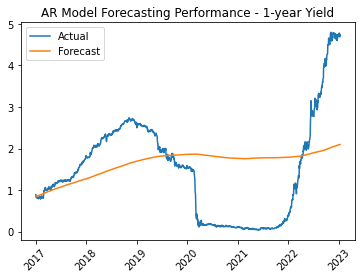

In [9]:
# compare forecasts to actuals
actuals = df.loc[(df['date'] >= start_forecast_date) & (df['date'] <= end_forecast_date), 'DGS1']
actuals_df = df.loc[(df['date'] >= start_forecast_date) & (df['date'] <= end_forecast_date), ['date', 'DGS1']]
ar_compare = pd.concat([actuals_df, ar_preds], axis = 1)
ar_compare.columns = ['date', 'actual', 'forecast']

plot_forecast_compare(ar_compare,
                      forecast_var_name = 'forecast', actual_var_name = 'actual',
                      title = 'AR Model Forecasting Performance - 1-year Yield')

## 10-year Treasury Yield

In [10]:
# choose optimal number of lags by BIC
opt_mod10 = ar_select_order(train_df['DGS10'], exog = train_df['DGS1_lag'], 
                          maxlag=15, ic = 'bic', missing = 'drop', old_names = False)
print(f'Chosen lags: {opt_mod10.ar_lags}')
# fit model with chosen number of lags and heteroskedastic-robust standard errors
mod10 = AutoReg(train_df['DGS10'], exog = train_df['DGS1_lag'], lags = 2, trend = 'c',
              missing = 'drop', old_names = False)
res10 = mod10.fit(cov_type="HC0")
print(res10.summary())

Chosen lags: [1 2]
                            AutoReg Model Results                             
Dep. Variable:                  DGS10   No. Observations:                13734
Model:                   AutoReg-X(2)   Log Likelihood               17774.416
Method:               Conditional MLE   S.D. of innovations              0.066
Date:                Thu, 23 Feb 2023   AIC                             -5.426
Time:                        04:24:26   BIC                             -5.423
Sample:                             2   HQIC                            -5.425
                                13734                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.002      2.203      0.028       0.000       0.008
DGS10.L1       1.0685      0.015     70.076      0.000       1.039       1.098
DGS10.L2      -0.0703      0.015 

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


In [11]:
# forecast
ar_preds_10 = res10.predict(start = start_forecast_index, end = end_forecast_index, 
                            exog_oos = test_df['DGS1_lag'], dynamic = False)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


RMSE: 1.303790316531816
MAPE: 85.31142329162003


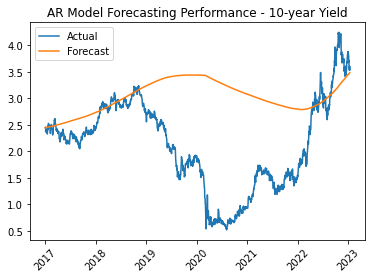

In [12]:
# compare forecasts to actuals
actuals_df10 = df.loc[(df['date'] >= start_forecast_date) & (df['date'] <= end_forecast_date), ['date', 'DGS10']]
ar_compare10 = pd.concat([actuals_df10, ar_preds_10], axis = 1)
ar_compare10.columns = ['date', 'actual', 'forecast']

plot_forecast_compare(ar_compare10,
                      forecast_var_name = 'forecast', actual_var_name = 'actual',
                      title = 'AR Model Forecasting Performance - 10-year Yield')

# LSTM Neural Network (Real Data)

Parts of code adapted from examples in: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [13]:
# function to reformat data from df to numpy array
def df_to_np(df, cols):
  """
    df: pandas DataFrame
    cols = list of column names from df to include
  """
  data = df[cols]
  data = data.to_numpy()
  return data

# function to split data into samples for NN
def split_NN_samples(data, n_steps):
  X, y = list(), list()
  for i in range(len(data)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the dataset
    if end_ix > len(data)-1:
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = data[i:end_ix, :], data[end_ix, :]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [14]:
# select features from df and # of steps for each sample
feature_cols = ['DGS1', 'DGS10']
n_steps = 25

# format training data
train_data = df_to_np(train_df, feature_cols)
train_x, train_y = split_NN_samples(data = train_data, n_steps = n_steps)
# train_x shape is (# of samples, # of steps, # of features)
print(train_x.shape)
n_features = train_x.shape[2]
# train_y shape is (# of samples, # of features)
print(train_y.shape)

(13710, 25, 2)
(13710, 2)


In [15]:
# define model
LSTM_model = Sequential()
LSTM_model.add(LSTM(25, activation='tanh', return_sequences=True, input_shape=(n_steps, n_features)))
LSTM_model.add(LSTM(25, activation='tanh'))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(Dense(n_features))
LSTM_model.compile(optimizer='adam', loss='mse')

**Option to load previously trained model or train new**

In [16]:
# if true, load a pretrained model instead of training
load_pretrain = True

if load_pretrain == True:
  LSTM_model = load_model("/content/drive/MyDrive/Models/LSTM_model")
else:
  # train model
  LSTM_model.fit(train_x, train_y, epochs = 50, verbose = 2)

In [18]:
# save model after training
#LSTM_model.save("/content/drive/MyDrive/Models/LSTM_model")

In [17]:
# format test data
test_df = df[(df['date'] > last_train_date) & (df['date'] <= end_forecast_date)]
test_data = df_to_np(test_df, feature_cols)
test_x, test_y = split_NN_samples(data = test_data, n_steps = n_steps)
# test_x shape is (# of samples, # of steps, # of features)
print(test_x.shape)
# test_y shape is (# of samples, # of features)
print(test_y.shape)

(1482, 25, 2)
(1482, 2)


In [19]:
# forecast on test data
yhat = LSTM_model.predict(test_x, verbose=0)

RMSE: 0.07695115610100488
MAPE: 7.793983525840269


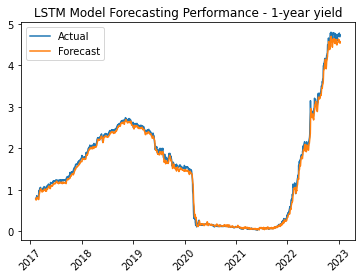

RMSE: 0.25251610804377284
MAPE: 15.90343148417441


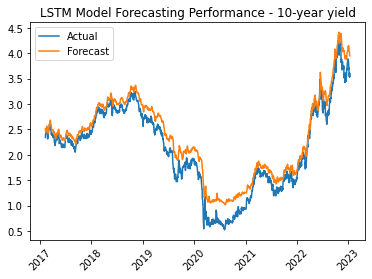

In [20]:
# format dates for comparison
date_compare = test_df['date'].reset_index(drop = True)
date_compare = date_compare[n_steps:].reset_index(drop = True)

# create dataframe for comparing forecasts to actual
LSTM_compare = pd.concat([pd.DataFrame(yhat), pd.DataFrame(test_y)], axis = 1)
LSTM_compare = pd.concat([date_compare, LSTM_compare], axis = 1)
LSTM_compare.columns = ['date', 'DGS1_pred', 'DGS10_pred', 'DGS1_actual', 'DGS10_actual']

# plot results
plot_forecast_compare(LSTM_compare, 
                      forecast_var_name = 'DGS1_pred', actual_var_name = 'DGS1_actual',
                      title = 'LSTM Model Forecasting Performance - 1-year yield')

plot_forecast_compare(LSTM_compare, 
                      forecast_var_name = 'DGS10_pred', actual_var_name = 'DGS10_actual',
                      title = 'LSTM Model Forecasting Performance - 10-year yield')

# LSTM Neural Network (Synthetic Data)

This model is trained on synthetic data, but tested on the same real data as above.

**The cell below will load the synthetic data used in the paper by default. To use custom generated synthetic data, simply change the file paths.**

In [21]:
# load synthetic data from DGAN_generation notebook
synthetic_features = np.loadtxt("https://raw.githubusercontent.com/sdannels/synthetic_time_series_forecasting/main/Data/synthetic_features_reshaped")
### WARNING: ENSURE THAT SHAPE OF DATA HAS NOT CHANGED IN DGAN_Generation NOTEBOOK ###############
synthetic_features = synthetic_features.reshape(1000, 125, 2)
synthetic_attributes = np.loadtxt("https://raw.githubusercontent.com/sdannels/synthetic_time_series_forecasting/main/Data/synthetic_attributes")
synthetic_attributes = synthetic_attributes.reshape(-1, 1)

In [22]:
# iterate through synthetic samples and split into training data
for i in range(synthetic_features.shape[0]):
  synth_train_x_iter, synth_train_y_iter = split_NN_samples(data = synthetic_features[i, :, :], n_steps = n_steps)
  # start with first sample and then append each array after that
  if i == 0:
    synth_train_x, synth_train_y = synth_train_x_iter, synth_train_y_iter
  else:
    synth_train_x = np.concatenate([synth_train_x, synth_train_x_iter], axis = 0)
    synth_train_y = np.concatenate([synth_train_y, synth_train_y_iter], axis = 0)

print(synth_train_x.shape)
print(synth_train_y.shape)

(100000, 25, 2)
(100000, 2)


In [23]:
# define model (should be same as model used for real data)
LSTM_synth_model = Sequential()
LSTM_synth_model.add(LSTM(25, activation='tanh', return_sequences=True, input_shape=(n_steps, n_features)))
LSTM_synth_model.add(LSTM(25, activation='tanh'))
LSTM_synth_model.add(Dropout(0.2))
LSTM_synth_model.add(Dense(n_features))
LSTM_synth_model.compile(optimizer='adam', loss='mse')

**Option to load previously trained model or train new**

In [24]:
# if true, load a pretrained model instead of training
load_synth_pretrain = True

if load_synth_pretrain == True:
  LSTM_synth_model = load_model("/content/drive/MyDrive/Models/LSTM_synth_model")
else:
  # train model
  LSTM_synth_model.fit(synth_train_x, synth_train_y, epochs = 50, verbose = 2)

In [25]:
# save model after training
#LSTM_synth_model.save("/content/drive/MyDrive/Models/LSTM_synth_model")

In [26]:
# forecast on test data (trained on synthetic data, but tested on real data)
yhat_synth = LSTM_synth_model.predict(test_x, verbose=0)

RMSE: 0.04622157404312103
MAPE: 9.412955065165479


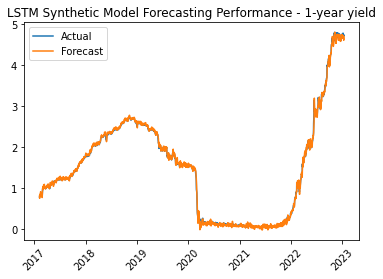

RMSE: 0.06220048120141645
MAPE: 2.7094694394807033


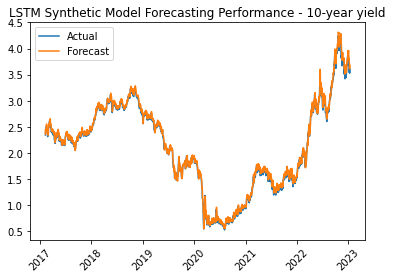

In [27]:
# format dates for comparison
date_compare = test_df['date'].reset_index(drop = True)
date_compare = date_compare[n_steps:].reset_index(drop = True)

# create dataframe for comparing forecasts to actual
LSTM_synth_compare = pd.concat([pd.DataFrame(yhat_synth), pd.DataFrame(test_y)], axis = 1)
LSTM_synth_compare = pd.concat([date_compare, LSTM_synth_compare], axis = 1)
LSTM_synth_compare.columns = ['date', 'DGS1_pred', 'DGS10_pred', 'DGS1_actual', 'DGS10_actual']

# plot results
plot_forecast_compare(LSTM_synth_compare, 
                      forecast_var_name = 'DGS1_pred', actual_var_name = 'DGS1_actual',
                      title = 'LSTM Synthetic Model Forecasting Performance - 1-year yield')

plot_forecast_compare(LSTM_synth_compare, 
                      forecast_var_name = 'DGS10_pred', actual_var_name = 'DGS10_actual',
                      title = 'LSTM Synthetic Model Forecasting Performance - 10-year yield')

# LSTM Neural Network (Combined data)

Real-data is combined with synthetic to augment the amount of available samples

In [28]:
# combine features for training
train_x_combined = np.concatenate([train_x, synth_train_x], axis = 0)
print(train_x_combined.shape)
train_y_combined = np.concatenate([train_y, synth_train_y], axis = 0)
print(train_y_combined.shape)

(113710, 25, 2)
(113710, 2)


In [29]:
# define model (should be same as model used for real data)
LSTM_comb_model = Sequential()
LSTM_comb_model.add(LSTM(25, activation='tanh', return_sequences=True, input_shape=(n_steps, n_features)))
LSTM_comb_model.add(LSTM(25, activation='tanh'))
LSTM_comb_model.add(Dropout(0.2))
LSTM_comb_model.add(Dense(n_features))
LSTM_comb_model.compile(optimizer='adam', loss='mse')

In [30]:
# if true, load a pretrained model instead of training
load_comb_pretrain = True

if load_comb_pretrain == True:
  LSTM_comb_model = load_model("/content/drive/MyDrive/Models/LSTM_comb_model")
else:
  # train model
  LSTM_comb_model.fit(train_x_combined, train_y_combined, epochs = 50, verbose = 2)

In [31]:
# save model after training
#LSTM_comb_model.save("/content/drive/MyDrive/Models/LSTM_comb_model")

In [32]:
# forecast on test data (trained on synthetic data, but tested on real data)
yhat_comb = LSTM_comb_model.predict(test_x, verbose=0)

RMSE: 0.0728752277955932
MAPE: 8.367648309650109


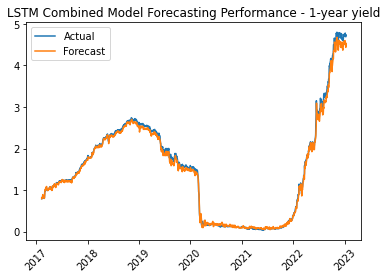

RMSE: 0.07293164119681735
MAPE: 3.484391473440874


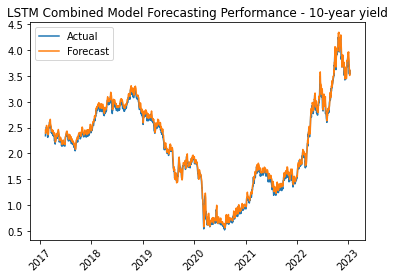

In [33]:
# format dates for comparison
date_compare = test_df['date'].reset_index(drop = True)
date_compare = date_compare[n_steps:].reset_index(drop = True)

# create dataframe for comparing forecasts to actual
LSTM_comb_compare = pd.concat([pd.DataFrame(yhat_comb), pd.DataFrame(test_y)], axis = 1)
LSTM_comb_compare = pd.concat([date_compare, LSTM_comb_compare], axis = 1)
LSTM_comb_compare.columns = ['date', 'DGS1_pred', 'DGS10_pred', 'DGS1_actual', 'DGS10_actual']

# plot results
plot_forecast_compare(LSTM_comb_compare, 
                      forecast_var_name = 'DGS1_pred', actual_var_name = 'DGS1_actual',
                      title = 'LSTM Combined Model Forecasting Performance - 1-year yield')

plot_forecast_compare(LSTM_comb_compare, 
                      forecast_var_name = 'DGS10_pred', actual_var_name = 'DGS10_actual',
                      title = 'LSTM Combined Model Forecasting Performance - 10-year yield')

# Multi-Step LSTM (Real Data)

In [34]:
n_steps_in = 25
# set number of steps ahead to forecast
n_steps_out = 15

# function to split samples for multiple steps ahead
def split_NN_samples_multistep(data, n_steps_in, n_steps_out):
 X, y = list(), list()
 for i in range(len(data)):
  # find the end of this pattern
  end_ix = i + n_steps_in
  out_end_ix = end_ix + n_steps_out
  # check if we are beyond the sequence
  if out_end_ix > len(data):
    break
  # gather input and output parts of the pattern
  seq_x, seq_y = data[i:end_ix, :], data[end_ix:out_end_ix, :]
  X.append(seq_x)
  y.append(seq_y)
 return np.array(X), np.array(y)

In [35]:
# create training samples
train_x_multi, train_y_multi = split_NN_samples_multistep(data = train_data, n_steps_in = n_steps_in, n_steps_out = n_steps_out)
# train_x shape is (# of samples, # of steps, # of features)
print(train_x_multi.shape)
n_features_multi = train_x_multi.shape[2]
# train_y shape is (# of samples, # of features)
print(train_y_multi.shape)

(13696, 25, 2)
(13696, 15, 2)


In [36]:
# format test data
test_x_multi, test_y_multi = split_NN_samples_multistep(data = test_data, n_steps_in = n_steps_in, n_steps_out = n_steps_out)
# test_x shape is (# of samples, # of steps, # of features)
print(test_x_multi.shape)
# test_y shape is (# of samples, # of features)
print(test_y_multi.shape)

(1468, 25, 2)
(1468, 15, 2)


In [37]:
# define model
LSTM_model_multi = Sequential()
LSTM_model_multi.add(LSTM(25, activation='tanh', return_sequences=True, input_shape=(n_steps_in, n_features_multi)))
LSTM_model_multi.add(LSTM(25, activation='tanh'))
LSTM_model_multi.add(Dropout(0.2))
LSTM_model_multi.add(Dense(n_steps_out*n_features_multi))
LSTM_model_multi.add(Reshape((n_steps_out, n_features_multi)))
LSTM_model_multi.compile(optimizer='adam', loss='mse')

In [38]:
# if true, load a pretrained model instead of training
load_multi_pretrain = True

if load_multi_pretrain == True:
  LSTM_model_multi = load_model("/content/drive/MyDrive/Models/LSTM_model_multi")
else:
  # train model
  LSTM_model_multi.fit(train_x_multi, train_y_multi, epochs = 50, verbose = 2)

In [39]:
# save model after training
#LSTM_model_multi.save("/content/drive/MyDrive/Models/LSTM_model_multi")

In [40]:
# forecast on test data
yhat_multi = LSTM_model_multi.predict(test_x_multi, verbose=0)

RMSE: 0.24445964332905099
MAPE: 77.73637869862219


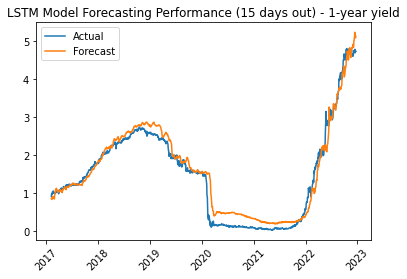

RMSE: 0.42545685466363564
MAPE: 25.07504438477421


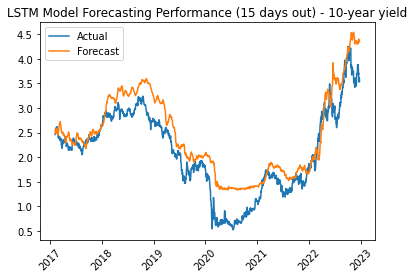

In [41]:
# pull the last day of the forecasts (e.g., if forecasting 15 days out, look at the forecast for day 15)
yhat_multi_last_day = yhat_multi[:, n_steps_out-1, :]
test_y_multi_last_day = test_y_multi[:, n_steps_out-1, :]

# create dataframe for comparing forecasts to actual
LSTM_compare_multi = pd.concat([pd.DataFrame(yhat_multi_last_day), pd.DataFrame(test_y_multi_last_day)], axis = 1)
LSTM_compare_multi = pd.concat([date_compare, LSTM_compare_multi], axis = 1)
LSTM_compare_multi.columns = ['date', 'DGS1_pred', 'DGS10_pred', 'DGS1_actual', 'DGS10_actual']
# drop days that don't have n_steps_out values yet
LSTM_compare_multi = LSTM_compare_multi.dropna()

# plot results
plot_forecast_compare(LSTM_compare_multi, 
                      forecast_var_name = 'DGS1_pred', actual_var_name = 'DGS1_actual',
                      title = f'LSTM Model Forecasting Performance ({n_steps_out} days out) - 1-year yield')

plot_forecast_compare(LSTM_compare_multi, 
                      forecast_var_name = 'DGS10_pred', actual_var_name = 'DGS10_actual',
                      title = f'LSTM Model Forecasting Performance ({n_steps_out} days out) - 10-year yield')

# Multi-Step LSTM (Synthetic Data)

In [42]:
# iterate through synthetic samples and split into training data
for i in range(synthetic_features.shape[0]):
  synth_train_x_iter, synth_train_y_iter = split_NN_samples_multistep(data = synthetic_features[i, :, :], 
                                                                      n_steps_in = n_steps_in, n_steps_out = n_steps_out)
  # start with first sample and then append each array after that
  if i == 0:
    synth_train_x_multi, synth_train_y_multi = synth_train_x_iter, synth_train_y_iter
  else:
    synth_train_x_multi = np.concatenate([synth_train_x_multi, synth_train_x_iter], axis = 0)
    synth_train_y_multi = np.concatenate([synth_train_y_multi, synth_train_y_iter], axis = 0)

print(synth_train_x_multi.shape)
print(synth_train_y_multi.shape)

(86000, 25, 2)
(86000, 15, 2)


In [43]:
# define model (should be the same as model used for real data)
LSTM_synth_model_multi = Sequential()
LSTM_synth_model_multi.add(LSTM(25, activation='tanh', return_sequences=True, input_shape=(n_steps_in, n_features_multi)))
LSTM_synth_model_multi.add(LSTM(25, activation='tanh'))
LSTM_synth_model_multi.add(Dropout(0.2))
LSTM_synth_model_multi.add(Dense(n_steps_out*n_features_multi))
LSTM_synth_model_multi.add(Reshape((n_steps_out, n_features_multi)))
LSTM_synth_model_multi.compile(optimizer='adam', loss='mse')

In [44]:
# if true, load a pretrained model instead of training
load_synth_multi_pretrain = True

if load_synth_multi_pretrain == True:
  LSTM_synth_model_multi = load_model("/content/drive/MyDrive/Models/LSTM_synth_model_multi")
else:
  # train model
  LSTM_synth_model_multi.fit(synth_train_x_multi, synth_train_y_multi, epochs = 50, verbose = 2)

In [45]:
# save model after training
#LSTM_synth_model_multi.save("/content/drive/MyDrive/Models/LSTM_synth_model_multi")

In [46]:
# forecast on test data (trained on synthetic data, test on real data)
yhat_synth_multi = LSTM_synth_model_multi.predict(test_x_multi, verbose=0)

RMSE: 0.3550570499411831
MAPE: 84.60979390899563


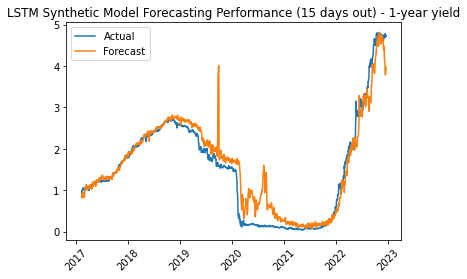

RMSE: 0.542581448232736
MAPE: 30.50273614021444


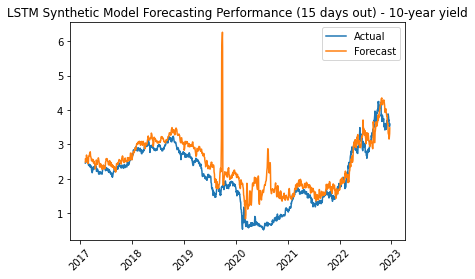

In [47]:
# pull the last day of the forecasts (e.g., if forecasting 15 days out, look at the forecast for day 15)
yhat_synth_multi_last_day = yhat_synth_multi[:, n_steps_out-1, :]
test_y_multi_last_day = test_y_multi[:, n_steps_out-1, :]

# create dataframe for comparing forecasts to actual
LSTM_synth_compare_multi = pd.concat([pd.DataFrame(yhat_synth_multi_last_day), pd.DataFrame(test_y_multi_last_day)], axis = 1)
LSTM_synth_compare_multi = pd.concat([date_compare, LSTM_synth_compare_multi], axis = 1)
LSTM_synth_compare_multi.columns = ['date', 'DGS1_pred', 'DGS10_pred', 'DGS1_actual', 'DGS10_actual']
# drop days that don't have n_steps_out values yet
LSTM_synth_compare_multi = LSTM_synth_compare_multi.dropna()

# plot results
plot_forecast_compare(LSTM_synth_compare_multi, 
                      forecast_var_name = 'DGS1_pred', actual_var_name = 'DGS1_actual',
                      title = f'LSTM Synthetic Model Forecasting Performance ({n_steps_out} days out) - 1-year yield')

plot_forecast_compare(LSTM_synth_compare_multi, 
                      forecast_var_name = 'DGS10_pred', actual_var_name = 'DGS10_actual',
                      title = f'LSTM Synthetic Model Forecasting Performance ({n_steps_out} days out) - 10-year yield')

#Multi-Step LSTM (Combined Data)

In [48]:
# combine features for training
train_x_combined_multi = np.concatenate([train_x_multi, synth_train_x_multi], axis = 0)
print(train_x_combined_multi.shape)
train_y_combined_multi = np.concatenate([train_y_multi, synth_train_y_multi], axis = 0)
print(train_y_combined_multi.shape)

(99696, 25, 2)
(99696, 15, 2)


In [49]:
# define model (should be the same as model used for real data)
LSTM_comb_model_multi = Sequential()
LSTM_comb_model_multi.add(LSTM(25, activation='tanh', return_sequences=True, input_shape=(n_steps_in, n_features_multi)))
LSTM_comb_model_multi.add(LSTM(25, activation='tanh'))
LSTM_comb_model_multi.add(Dropout(0.2))
LSTM_comb_model_multi.add(Dense(n_steps_out*n_features_multi))
LSTM_comb_model_multi.add(Reshape((n_steps_out, n_features_multi)))
LSTM_comb_model_multi.compile(optimizer='adam', loss='mse')

In [50]:
# if true, load a pretrained model instead of training
load_comb_multi_pretrain = True

if load_comb_multi_pretrain == True:
  LSTM_comb_model_multi = load_model("/content/drive/MyDrive/Models/LSTM_comb_model_multi")
else:
  # train model
  LSTM_comb_model_multi.fit(train_x_combined_multi, train_y_combined_multi, epochs = 50, verbose = 2)

In [51]:
# save model after training
#LSTM_comb_model_multi.save("/content/drive/MyDrive/Models/LSTM_comb_model_multi")

In [52]:
# forecast on test data (trained on synthetic data, test on real data)
yhat_comb_multi = LSTM_comb_model_multi.predict(test_x_multi, verbose=0)

RMSE: 0.30704274649361935
MAPE: 58.44795704980691


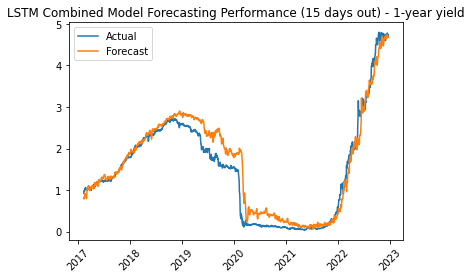

RMSE: 0.2693334304054836
MAPE: 13.556826358241858


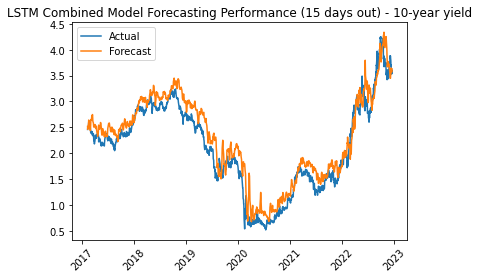

In [53]:
# pull the last day of the forecasts (e.g., if forecasting 15 days out, look at the forecast for day 15)
yhat_comb_multi_last_day = yhat_comb_multi[:, n_steps_out-1, :]
test_y_multi_last_day = test_y_multi[:, n_steps_out-1, :]

# create dataframe for comparing forecasts to actual
LSTM_comb_compare_multi = pd.concat([pd.DataFrame(yhat_comb_multi_last_day), pd.DataFrame(test_y_multi_last_day)], axis = 1)
LSTM_comb_compare_multi = pd.concat([date_compare, LSTM_comb_compare_multi], axis = 1)
LSTM_comb_compare_multi.columns = ['date', 'DGS1_pred', 'DGS10_pred', 'DGS1_actual', 'DGS10_actual']
# drop days that don't have n_steps_out values yet
LSTM_comb_compare_multi = LSTM_comb_compare_multi.dropna()

# plot results
plot_forecast_compare(LSTM_comb_compare_multi, 
                      forecast_var_name = 'DGS1_pred', actual_var_name = 'DGS1_actual',
                      title = f'LSTM Combined Model Forecasting Performance ({n_steps_out} days out) - 1-year yield')

plot_forecast_compare(LSTM_comb_compare_multi, 
                      forecast_var_name = 'DGS10_pred', actual_var_name = 'DGS10_actual',
                      title = f'LSTM Combined Model Forecasting Performance ({n_steps_out} days out) - 10-year yield')

#Plot overall comparisons

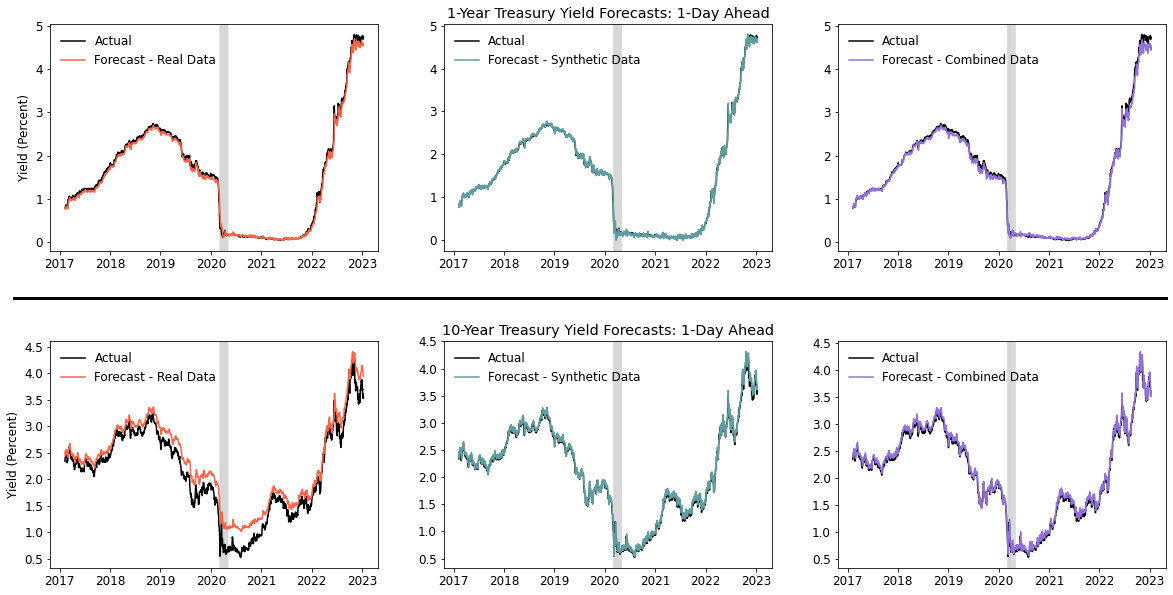

In [54]:
# set font
plt.rcParams.update({'font.size': 12})

# set colors
compare_colors = ['tomato', 'cadetblue', 'mediumpurple']

# set recession data
recessions = test_df.date[test_df['USRECD'] == 1]

# configure plot
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(20)
ax1 = plt.subplot2grid((2, 3), (0, 0))
ax2 = plt.subplot2grid((2, 3), (0, 1))
ax3 = plt.subplot2grid((2, 3), (0, 2))
ax4 = plt.subplot2grid((2, 3), (1, 0))
ax5 = plt.subplot2grid((2, 3), (1, 1))
ax6 = plt.subplot2grid((2, 3), (1, 2))
plt.subplots_adjust(hspace=0.4)


# set up data series for 1-year
ax1.plot(LSTM_compare['date'], LSTM_compare['DGS1_actual'], label = 'Actual', color = 'black')
ax2.plot(LSTM_compare['date'], LSTM_compare['DGS1_actual'], label = 'Actual', color = 'black')
ax3.plot(LSTM_compare['date'], LSTM_compare['DGS1_actual'], label = 'Actual', color = 'black')
ax1.plot(LSTM_compare['date'], LSTM_compare['DGS1_pred'], label = 'Forecast - Real Data', color = compare_colors[0])
ax2.plot(LSTM_compare['date'], LSTM_synth_compare['DGS1_pred'], label = 'Forecast - Synthetic Data', color = compare_colors[1])
ax3.plot(LSTM_compare['date'], LSTM_comb_compare['DGS1_pred'], label = 'Forecast - Combined Data', color = compare_colors[2])
ax1.set(ylabel = 'Yield (Percent)')
ax2.set(title = '1-Year Treasury Yield Forecasts: 1-Day Ahead')
ax1.legend(frameon = False)
ax2.legend(frameon = False)
ax3.legend(frameon = False)

# add recessions to 1-year plots
for day in recessions:
    ax1.axvspan(day, day + dt.timedelta(days=1), color="lightgrey", alpha=0.25)
    ax2.axvspan(day, day + dt.timedelta(days=1), color="lightgrey", alpha=0.25)
    ax3.axvspan(day, day + dt.timedelta(days=1), color="lightgrey", alpha=0.25)

# set up data series for 10-year
ax4.plot(LSTM_compare['date'], LSTM_compare['DGS10_actual'], label = 'Actual', color = 'black')
ax5.plot(LSTM_compare['date'], LSTM_compare['DGS10_actual'], label = 'Actual', color = 'black')
ax6.plot(LSTM_compare['date'], LSTM_compare['DGS10_actual'], label = 'Actual', color = 'black')
ax4.plot(LSTM_compare['date'], LSTM_compare['DGS10_pred'], label = 'Forecast - Real Data', color = compare_colors[0])
ax5.plot(LSTM_compare['date'], LSTM_synth_compare['DGS10_pred'], label = 'Forecast - Synthetic Data', color = compare_colors[1])
ax6.plot(LSTM_compare['date'], LSTM_comb_compare['DGS10_pred'], label = 'Forecast - Combined Data', color = compare_colors[2])
ax4.set(ylabel = 'Yield (Percent)')
ax5.set(title = '10-Year Treasury Yield Forecasts: 1-Day Ahead')
ax4.legend(frameon = False)
ax5.legend(frameon = False)
ax6.legend(frameon = False)

# add recessions to 10-year plots
for day in recessions:
    ax4.axvspan(day, day + dt.timedelta(days=1), color="lightgrey", alpha=0.25)
    ax5.axvspan(day, day + dt.timedelta(days=1), color="lightgrey", alpha=0.25)
    ax6.axvspan(day, day + dt.timedelta(days=1), color="lightgrey", alpha=0.25)

# add line between top and bottom rows
ax4.plot([0.1, 0.9], [0.5, 0.5], color='black', lw=3,
         transform=plt.gcf().transFigure, clip_on=False)

# save plot
#fig.savefig('/content/drive/MyDrive/Figures/forecasts_1day.pdf', format = 'pdf', bbox_inches = 'tight')

fig.show()

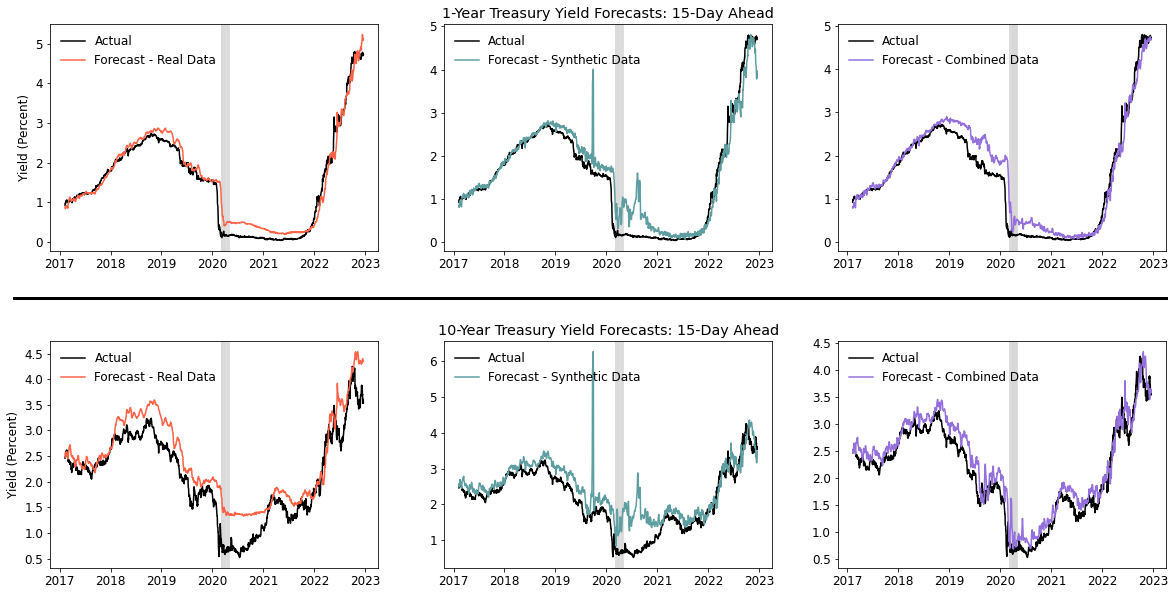

In [55]:
# set font
plt.rcParams.update({'font.size': 12})

# set colors
compare_colors = ['tomato', 'cadetblue', 'mediumpurple']

# set recession data
recessions = test_df.date[test_df['USRECD'] == 1]

# configure plot
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(20)
ax1 = plt.subplot2grid((2, 3), (0, 0))
ax2 = plt.subplot2grid((2, 3), (0, 1))
ax3 = plt.subplot2grid((2, 3), (0, 2))
ax4 = plt.subplot2grid((2, 3), (1, 0))
ax5 = plt.subplot2grid((2, 3), (1, 1))
ax6 = plt.subplot2grid((2, 3), (1, 2))
plt.subplots_adjust(hspace=0.4)


# set up data series for 1-year
ax1.plot(LSTM_compare_multi['date'], LSTM_compare_multi['DGS1_actual'], label = 'Actual', color = 'black')
ax2.plot(LSTM_compare_multi['date'], LSTM_compare_multi['DGS1_actual'], label = 'Actual', color = 'black')
ax3.plot(LSTM_compare_multi['date'], LSTM_compare_multi['DGS1_actual'], label = 'Actual', color = 'black')
ax1.plot(LSTM_compare_multi['date'], LSTM_compare_multi['DGS1_pred'], label = 'Forecast - Real Data', color = compare_colors[0])
ax2.plot(LSTM_compare_multi['date'], LSTM_synth_compare_multi['DGS1_pred'], label = 'Forecast - Synthetic Data', color = compare_colors[1])
ax3.plot(LSTM_compare_multi['date'], LSTM_comb_compare_multi['DGS1_pred'], label = 'Forecast - Combined Data', color = compare_colors[2])
ax1.set(ylabel = 'Yield (Percent)')
ax2.set(title = '1-Year Treasury Yield Forecasts: 15-Day Ahead')
ax1.legend(frameon = False)
ax2.legend(frameon = False)
ax3.legend(frameon = False)

# add recessions to 1-year plots
for day in recessions:
    ax1.axvspan(day, day + dt.timedelta(days=1), color="lightgrey", alpha=0.25)
    ax2.axvspan(day, day + dt.timedelta(days=1), color="lightgrey", alpha=0.25)
    ax3.axvspan(day, day + dt.timedelta(days=1), color="lightgrey", alpha=0.25)

# set up data series for 10-year
ax4.plot(LSTM_compare_multi['date'], LSTM_compare_multi['DGS10_actual'], label = 'Actual', color = 'black')
ax5.plot(LSTM_compare_multi['date'], LSTM_compare_multi['DGS10_actual'], label = 'Actual', color = 'black')
ax6.plot(LSTM_compare_multi['date'], LSTM_compare_multi['DGS10_actual'], label = 'Actual', color = 'black')
ax4.plot(LSTM_compare_multi['date'], LSTM_compare_multi['DGS10_pred'], label = 'Forecast - Real Data', color = compare_colors[0])
ax5.plot(LSTM_compare_multi['date'], LSTM_synth_compare_multi['DGS10_pred'], label = 'Forecast - Synthetic Data', color = compare_colors[1])
ax6.plot(LSTM_compare_multi['date'], LSTM_comb_compare_multi['DGS10_pred'], label = 'Forecast - Combined Data', color = compare_colors[2])
ax4.set(ylabel = 'Yield (Percent)')
ax5.set(title = '10-Year Treasury Yield Forecasts: 15-Day Ahead')
ax4.legend(frameon = False)
ax5.legend(frameon = False, loc = 'upper left')
ax6.legend(frameon = False)

# add recessions to 10-year plots
for day in recessions:
    ax4.axvspan(day, day + dt.timedelta(days=1), color="lightgrey", alpha=0.25)
    ax5.axvspan(day, day + dt.timedelta(days=1), color="lightgrey", alpha=0.25)
    ax6.axvspan(day, day + dt.timedelta(days=1), color="lightgrey", alpha=0.25)

# add line between top and bottom rows
ax4.plot([0.1, 0.9], [0.5, 0.5], color='black', lw=3,
         transform=plt.gcf().transFigure, clip_on=False)

# save plot
#fig.savefig('/content/drive/MyDrive/Figures/forecasts_15day.pdf', format = 'pdf', bbox_inches = 'tight')

fig.show()